In [1]:
import os
from scTrace.pipeline import *

E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Run scTrace+ on LARRY In vitro differentiation time course

#### Load data: [Larry-Invitro-differentiation](https://cloud.tsinghua.edu.cn/f/1b94b3229f4a4c52985e/?dl=1)

In [2]:
dataSet = "Science20-Larry"
samName = "In vitro diff"
run_label = dataSet + "_" + samName

dataPath = "D:/Lineage-data/Science2020-Larry/Science2020-Larry-example/"

# In vitro differentiation time course
data_4 = sc.read(dataPath + 'D4_larry_diff_scobj.h5ad')
data_6 = sc.read(dataPath + 'D6_larry_diff_scobj.h5ad')

In [3]:
savePath = "D:/Lineage-data/Science2020-Larry/Results/" # + run_label + "/"

if not os.path.exists(savePath):
    os.makedirs(savePath)

colors = [#['#B5A2E0', '#F9B475', '#50C7CA', '#CF747A', '#63AFF0', '#8792AF', '#E0CB00', '#DC7EC0'],
          ["#43D9FE", "#E78AC3", "#FEC643", "#A6D854", "#FE6943", "#E5C494", "#33AEB1", "#FFEC1A", "#4878D0", '#984EA3', 
           '#CF747A', '#4DAF4A', '#C2C2C2'],
          ["#66C2A5", "#FC8D62", "#8DA0CB", "#E78AC3", "#A6D854", "#FFD92F", "#E5C494", "#4878D0", "#6ACC64", "#82C6E2",
           "#D65F5F", "#43D9FE", '#B383C1', '#BC8967', "#B3B3B3"]]

In [4]:
all_data = [data_4, data_6]
print(data_4.shape)
print(data_6.shape)
all_names = ['Day4', 'Day6']

(24249, 4586)
(27070, 4586)


#### Only 2 time points in demo, set time = 0

In [5]:
time = 0

In [6]:
data_pre, data_pos = all_data[time:(time+2)]
pre_name, pos_name = all_names[time:(time+2)]

pre_colors = colors[time]
pos_colors = colors[time+1]

n_pre = data_pre.shape[0]
n_pos = data_pos.shape[0]
run_label_time = run_label + '-' + pre_name + '_' + pos_name
print(run_label_time)

Science20-Larry_In vitro diff-Day4_Day6


#### `prepareCrosstimeGraph`: Process input time-series dataset, output lineage adjacency matrices and transcriptome similarity matrices, both within and across timepoints.
#### `lineage_identity` refers to the name of columns containing lineage information in "obs" of scanpy object.

Number of cells in the former time point:  24249
Number of cells with flow-out information:  5385
Flow-out density:  0.2220710132376593
Number of cells in the latter time point:  27070
Number of cells with flow-in information:  11215
Flow-in density:  0.4142962689323975
Generating mother-daughter similarity
0.8830743202212131 0.9004875688405469


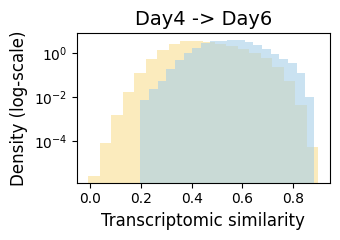

In [7]:
cross_sp_df, cross_lin_mat, barcodes_pre, barcodes_pos = prepareCrosstimeGraph(data_pre=data_pre, data_pos=data_pos,
                                                                               lineage_identity='Clone',
                                                                               pre_name=pre_name, pos_name=pos_name,
                                                                               savePath=savePath, run_label_time=run_label_time)

#### `prepareWithintimeGraph`: Optional, for visualization only

Generating mother-daughter similarity (with-in timepoint)
0.9029274106052435 0.8868751101651757


0

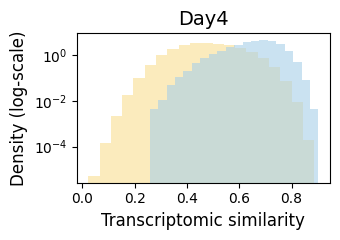

In [13]:
sim, within_lin_mat = prepareWithintimeGraph(data_pre=data_pre,data_pos=data_pos,
                                             lineage_identity='Clone',
                                             pre_name=pre_name, pos_name=pos_name,
                                             savePath=savePath, run_label_time=run_label_time,
                                             mode='pre')
del(sim, within_lin_mat)
gc.collect()

Generating mother-daughter similarity (with-in timepoint)
0.870763833250653 0.8992607727109081


0

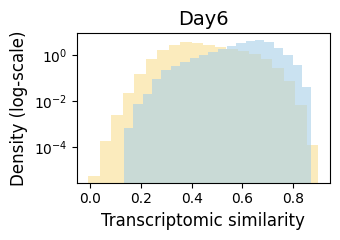

In [14]:
sim, within_lin_mat = prepareWithintimeGraph(data_pre=data_pre,data_pos=data_pos,
                                             lineage_identity='Clone',
                                             pre_name=pre_name, pos_name=pos_name,
                                             savePath=savePath, run_label_time=run_label_time,
                                             mode='pos')
del(sim, within_lin_mat)
gc.collect()

#### `prepareSideInformation`:  Derive low-dimensional side information matrix (Ku, Kv) with `node2vec` and `rbf kernel` (run only-once)，

In [ ]:
prepareSideInformation(data_pre=data_pre, data_pos=data_pos,
                       barcodes_pre=barcodes_pre, barcodes_pos=barcodes_pos,
                       savePath=savePath,
                       run_label_time=run_label_time,
                       single_inte_fraction=0.5)

#### Split training-validation sets for performance evaluation

In [8]:
train_df, val_df = train_valid_split(cross_sp_df, ratio=0.2, type="stratified")

Splitting train-validation set


#### `trainMF`: Train scLTMF model to predict the missing entries in the original across-timepoint transition matrix.

In [ ]:
hyper_dict, model = trainMF(train_df=train_df,
                            val_df=val_df,
                            n_pre=n_pre, n_pos=n_pos,
                            savePath=savePath,
                            run_label_time=run_label_time,
                            n_factor=20,
                            n_epoch=300,
                            bool_pre_side=True, bool_post_side=True,
                            learning_rate=0.01, regularization=0.0001)

#### `predictMissingEntries`: Load pretrained scLTMF model and calculate performance evaluation indicators.
#### Here we set a threshold manually. You can also set the cut-off according to data distribution, see below.

Loading pretrained model...


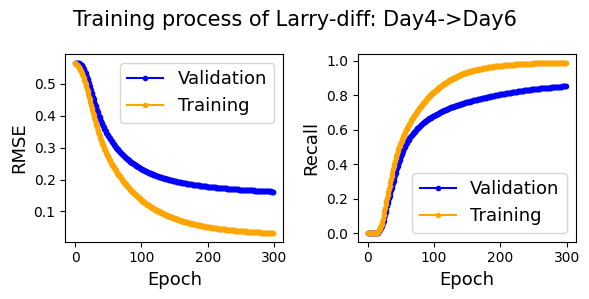

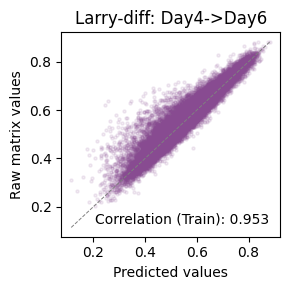

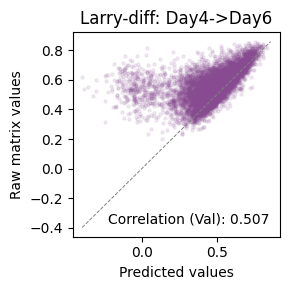

In [8]:
pred_mat, y_true, y_pred, complet_mat, corr, min_rmse, max_recall = predictMissingEntries(pre_name=pre_name,
                                                                                          pos_name=pos_name,
                                                                                          savePath=savePath,
                                                                                          run_label_time=run_label_time,
                                                                                          showName="Larry-diff")

#### Training on full dataset for downstream analysis

In [ ]:
hyper_dict, model = trainMF(train_df=cross_sp_df,
                            val_df=cross_sp_df,
                            n_pre=n_pre, n_pos=n_pos,
                            savePath=savePath,
                            run_label_time=run_label_time,
                            n_factor=20,
                            n_epoch=300,
                            bool_pre_side=True, bool_post_side=True,
                            learning_rate=0.01, regularization=0.0001)

#### Load full model for downstream analysis

In [9]:
# Please move/rename the model or modify the following path
model = load_model(savePath + "model/" + run_label_time + '_model_full.pkl')
complet_mat = np.dot(model.p, model.q.T)

#### Automatically set the cut-off according to data distribution

In [10]:
basic_values = complet_mat.reshape((1, -1))[0][cross_lin_mat.reshape((1, -1))[0] > 0]
Q1, Q3 = np.percentile(basic_values, 25), np.percentile(basic_values, 75)
threshold = Q1 - 1.5 * (Q3 - Q1)
print(threshold)
complet_mat[complet_mat < threshold] = 0

0.27547700661918517


#### `prepareScdobj`: Prepare `scStateDynamics` objects and perform clustering method.


## 1. Identify cell clusters and cell states ---------------------------


E:\Software\Anaconda\installation\envs\scTrace_env\lib\site-packages\scStateDynamics\scStateDynamics.py:37: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(scobj, key_added='cluster', resolution=cls_res)


| - N_cells: [24249, 27070]
| - N_clusters: [6 6]
| - N_cliques: [810 787]
| - Saving figure: D:/Lineage-data/Science2020-Larry/Results/Science20-Larry_In vitro diff-Day4_Day6_Cell-PairUMAP.png


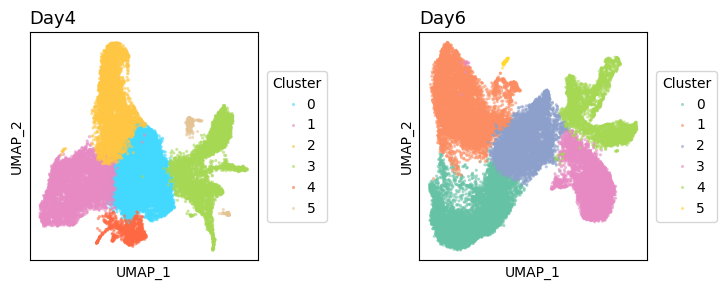

In [11]:
cls_res_all = [0.07, 0.07] # diff data, 0.05 for perturb data
cls_res_all = [0.1, 0.1] # diff data, 0.05 for perturb data
clq_res_all = [50, 50]

scd_obj = prepareScdobj(data_pre=data_pre, data_pos=data_pos,
                        time=time,
                        pre_name=pre_name, pos_name=pos_name,
                        cls_res_all=cls_res_all, clq_res_all=clq_res_all,
                        pre_colors=pre_colors, pos_colors=pos_colors,
                        savePath=savePath, run_label_time=run_label_time)

#### `visualizeLineageInfo` & `visualizeEnhancedLineageInfo`: Visualize cluster alignment results with Sankey plot. 

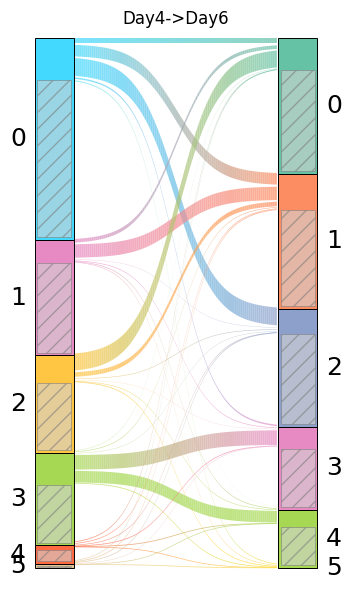

In [12]:
cls_lineage_mat, flow_info = visualizeLineageInfo(scd_obj=scd_obj,
                                                  cross_lin_mat=cross_lin_mat,
                                                  n_pre=n_pre, 
                                                  pre_colors=pre_colors, pos_colors=pos_colors,
                                                  pre_name=pre_name, pos_name=pos_name,
                                                  savePath=savePath,
                                                  run_label_time=run_label_time)

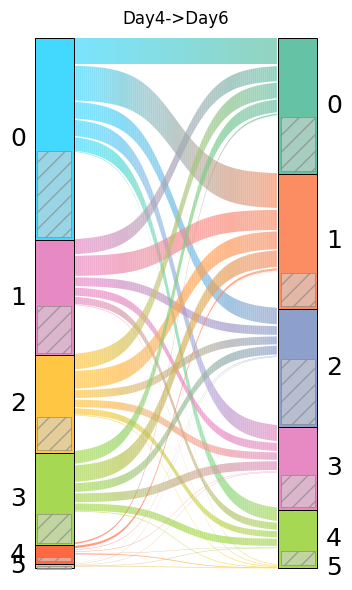

In [13]:
cls_trans_mat, flow_info_enhanced = visualizeEnhancedLineageInfo(scd_obj=scd_obj,
                                                                 complet_mat=complet_mat,
                                                                 n_pre=n_pre, 
                                                                 pre_colors=pre_colors, pos_colors=pos_colors,
                                                                 pre_name=pre_name, pos_name=pos_name,
                                                                 savePath=savePath,
                                                                 run_label_time=run_label_time)

#### `assignLineageInfo`: Assign fate information at single-cell level and output a `cell2cluster` matrix according to lineage information.

In [14]:
scd_obj = assignLineageInfo(scd_obj,
                            cross_lin_mat,
                            savePath,
                            run_label_time,
                            sel_cluster_name="Cell type annotation")

#### `enhanceFate`: Enhance cell fate information based on hypothesis testing method for single-cell level fate inference.

In [15]:
adata_pre, enhance_rate = enhanceFate(scd_obj,
                                      complet_mat,
                                      savePath,
                                      run_label_time,
                                      cluster_name='Cell type annotation')

100%|██████████| 24249/24249 [00:15<00:00, 1552.73it/s]
E:\Lineage\Code\scTrace\scTrace\pipeline.py:258: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if adata_pre.obs[enhanced_fate_colname][i] == "Missing":
E:\Lineage\Code\scTrace\scTrace\pipeline.py:260: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = val

Ratio of newly added fate clusters: 0.2195


#### Run DEGs (before and after enhancement)

#### `runFateDE`: Perform differential expression analysis between selected dynamic sub-clusters.

In [16]:
sel_cls = 'Undifferentiated'
# sel_fates = ['Undifferentiated -> Undifferentiated', 'Undifferentiated -> Monocyte']
sel_fates = ['Undifferentiated -> Undifferentiated', 'Undifferentiated -> Neutrophil']
cls_colname, fate_colname = 'Cell type annotation', 'Lineage_fate_label'
lt_sub_expr, lt_de = runFateDE(adata_pre, fate_colname, sel_cls, sel_fates, 
                               saveName = savePath + run_label_time + '_DE_fate_genes-' + sel_cls + '_' + fate_colname.split('_')[0] + '.txt')
cls_colname, fate_colname = 'Cell type annotation', 'Enhanced_fate_label'
eh_sub_expr, eh_de = runFateDE(adata_pre, fate_colname, sel_cls, sel_fates, 
                            saveName = savePath + run_label_time + '_DE_fate_genes-' + sel_cls + '_' + fate_colname.split('_')[0] + '.txt')

#### `dynamicDiffAnalysis`: Perform differential expression analysis between all dynamic sub-clusters. (1 v.s. rest)

In [17]:
all_de_df_lt = dynamicDiffAnalysis(scd_obj, savePath, run_label_time,
                                   sel_cluster_name="Cell type annotation",
                                   fate_colname='Lineage_fate',
                                   special_case="Missing")
all_de_df_enhanced = dynamicDiffAnalysis(scd_obj, savePath, run_label_time,
                                         sel_cluster_name="Cell type annotation",
                                         fate_colname='Enhanced_fate',
                                         special_case="Uncertain")

division by zero


#### Save results

In [18]:
pre_df = adata_pre.obs[['cluster', 'Cell type annotation', 'Lineage_fate', 'Lineage_fate_label', 'Enhanced_fate', 'Enhanced_fate_label']]
pre_df.to_csv(savePath + run_label_time + ' - res_anno' + '_'  + str(threshold) + '.txt', sep = '\t')